# **Clustering the Data**

## Objectives

* We will investigate the data using clustering algoritthms to investigate our hypothesis # something

## Inputs

* The game data from before the train test split at the beginning of notebook 04. 

## Outputs

* A clustering model and some analysis of the underlying data set.



---

# Change working directory
We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os

home_dir = '/workspace/pp5-ml-dashboard'
os.chdir(home_dir)
current_dir = os.getcwd()
print(current_dir)

/workspace/pp5-ml-dashboard


We now load our prepared data.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from src.utils import get_df, save_df

game_data = get_df('game_pre_split', 'datasets/clean/csv')

## Section 1: Set up problem
The game of basketball as evolved over the years. For example, we saw in our exploratory data analysis that there was a correlation between 3 pointers and year. We are going to test if clustering will detect the various eras of basketball, or perhaps it will define new ones.

We will then look at the profiles of each cluster to see how it groups games of basketball and try to determine if these clusters have any correlation with time.



In [3]:
#game_data.drop(labels=['season'],inplace=True,axis=1)
game_data.head()

,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,oreb_home,dreb_home,reb_home,ast_home,...,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,home_wins,play_off,season
0,41,92,0,3,9,18,16,28,44,25,...,40,21,11,7,17,19,100,0,0,0
1,39,88,0,2,26,41,20,28,48,17,...,42,19,7,7,18,32,108,0,0,0
2,39,88,0,1,40,49,17,40,57,23,...,41,27,10,7,20,32,116,1,0,0
3,42,82,0,2,24,38,10,24,34,30,...,47,23,10,7,19,28,112,0,0,0
4,36,91,0,4,33,52,18,29,47,17,...,44,26,11,3,22,40,119,0,0,0


Now we construct our pipeline for clustering. The format for the pipeline was inspired by the clustering pipeline in the Churnometer walkthrough project.

In [4]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def cluster_pipe(thresh=0.7,p_components=50,clusters=50):
    pipe = Pipeline([
        ("corr_selector", SmartCorrelatedSelection(method="pearson",
                                                   threshold=thresh, 
                                                   selection_method="variance")),
        ("scaler", StandardScaler()),
        ("PCA", PCA(n_components=p_components, random_state=42)),
        ("model", KMeans(n_clusters=clusters, random_state=42)),
    ])
    return pipe

We will end up tuning the number of clusters and components as hyperparameters. It will be interesting to luck at how the analysis changes as we move between the number of clusters. At each stage, we will see how the function that assigns each game to its season behaves on clusters.

## Section 2: PCA
We start by doing some Principal component analysis.

In [5]:
# to suppress warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logging.captureWarnings(True)
os.environ['PYTHONWARNINGS']='ignore'

pipe = cluster_pipe()
pca_pipe = Pipeline(pipe.steps[:-2])
game_data_pca = pca_pipe.fit_transform(game_data)


We are now going to analyze the principal components. Feel free to adjust the number of components.

* The 15 components explain 97.3% of the data 



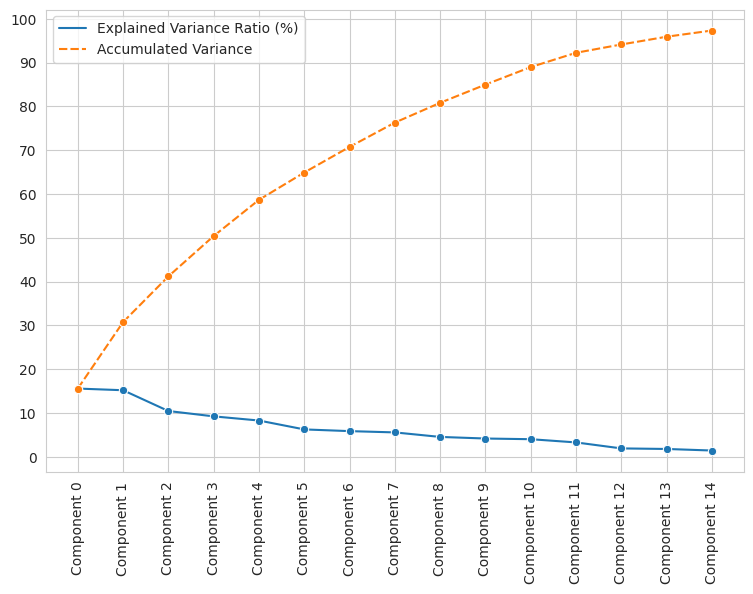

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# This function is from the notebook 07 of the 
# churnometer walkthrough project.
def pca_component_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = [f"Component {number}"
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )
    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )
    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_component_analysis(game_data_pca, 15)


As we are hoping the data will be grouped into eras, each of which is multiple years long. We expect there to be a fair number of clusters, so we don't mind having many components.

In [7]:
pca_component_analysis(game_data_pca,9)


Now we need to use the elbow method and look at silhouette scores.

## Section 3: Elbow Method and Silhouette scores
These will help us determine the appropriate number of clusters to use for our algorithm. We are also taking into account some domain knowledge, which is that eras in basketball range from 6 to 10 years. It is not a well defined concept so we don't have a hard number. Our data set ranges from 1985 until 2022. So we (conservatively) expect there to be between 4 and 7 eras.

In [ ]:
new_pipe = cluster_pipe(p_components=9)
pca_part_of_pipe = Pipeline(new_pipe.steps[:-1])
game_data_pca = pca_part_of_pipe.fit_transform(game_data)

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(random_state=42), k=(1,11)) # 11 is not inclusive, it will plot until 10
visualizer.fit(game_data_pca) 
visualizer.show() 
plt.show()

ImportError: cannot import name '_is_pairwise' from 'sklearn.base' (/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/base.py)